# System configuration

In [1]:
!git clone https://github.com/inkyubeytor/explainability-challenges.git

fatal: destination path 'explainability-challenges' already exists and is not an empty directory.


# Preamble

In [2]:
import sys
import torch
import requests
import torchvision
import numpy as np

sys.path.insert(1, "./explainability-challenges/src/")

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
from explainability.image.image_attacks import blur_attack, dual_class_attack, \
    noise_attack, occlusion_attack, ood_attack, adversarial_attack

/opt/homebrew/Caskroom/miniconda/base/envs/10713/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/envs/10713/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/10713/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

def huggingface_to_tensor(image_list):
    image_array_list = [transform(image.convert('RGB')) for image in image_list]
    #image_array = np.stack(image_array_list, dim=0)

    return torch.stack(image_array_list)

In [4]:
dataset = load_dataset("frgfm/imagenette", "full_size", split="validation")
ood_dataset = huggingface_to_tensor(load_dataset("frgfm/imagewoof", "full_size", split="validation")['image'])
far_ood_dataset = huggingface_to_tensor(load_dataset("jbarat/plant_species", split='train')['image'])

Found cached dataset imagenette (/Users/jrast/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)
Found cached dataset imagewoof (/Users/jrast/.cache/huggingface/datasets/frgfm___imagewoof/full_size/1.0.0/27966bf439ec61d39fbb620b6c493290e3f75307ab7a7b4d979c61cfe5237a48)
Found cached dataset parquet (/Users/jrast/.cache/huggingface/datasets/jbarat___parquet/jbarat--plant_species-efbaed60a3c7fd6e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


# Exploring image attacks

In [5]:
def show_image(img):
    img = img.squeeze().permute(1,2,0)
    plt.imshow(img)

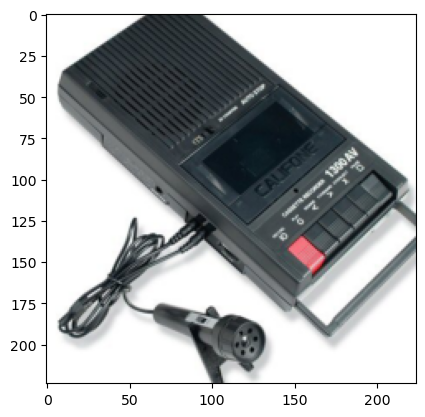

In [6]:
img = dataset[0]['image']
img = image = (transform(img) * 255).int().float()

show_image(img / 255)

## Noise attack

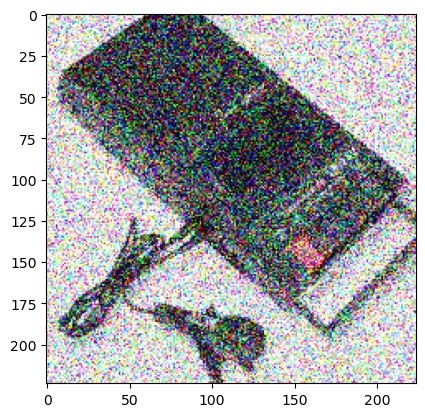

In [7]:
noisy_img = noise_attack(img, std=100)

show_image(noisy_img / 255)

## Blur attack

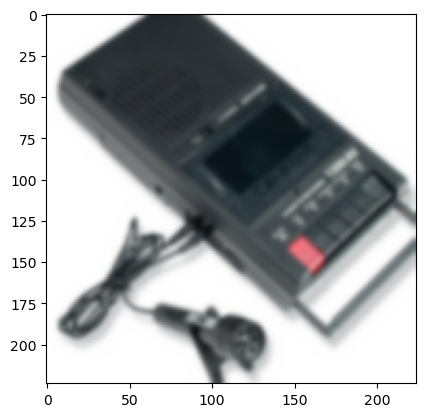

In [8]:
blurry_img = blur_attack(img)

show_image(blurry_img)

# Occlusion attack

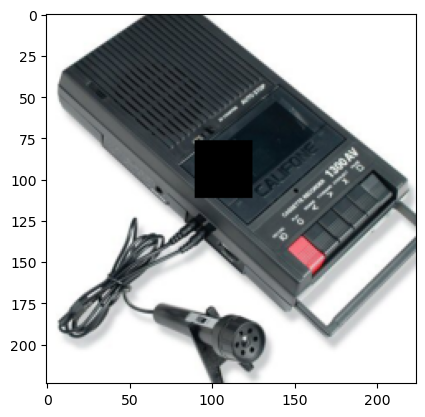

In [9]:
occluded_img = occlusion_attack(img)

show_image(occluded_img)

## Dual class attack

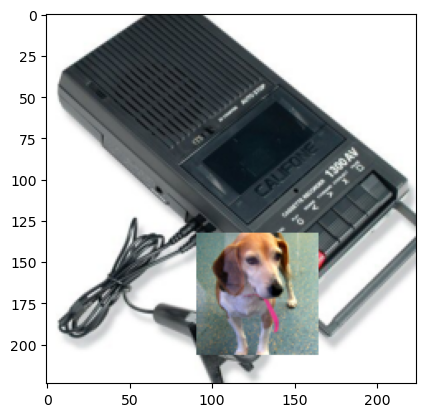

In [10]:
dual_class_img = dual_class_attack(img, ood_dataset)

show_image(dual_class_img)

## OOD attack

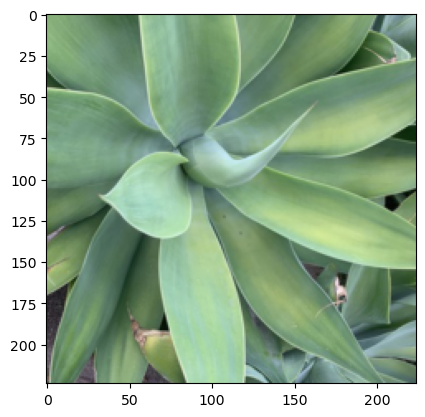

In [12]:
ood_img = ood_attack(far_ood_dataset)

show_image(ood_img)

## Adversarial attack

/Users/jrast/Documents/archive/2020 to 2023 CMU/Coursework/Spring 23/10713/Project/demos/./explainability-challenges/src/explainability/image/core/image_manipulator.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  label = torch.nn.functional.softmax(model(transform(self.image).to('cpu'))).argmax()


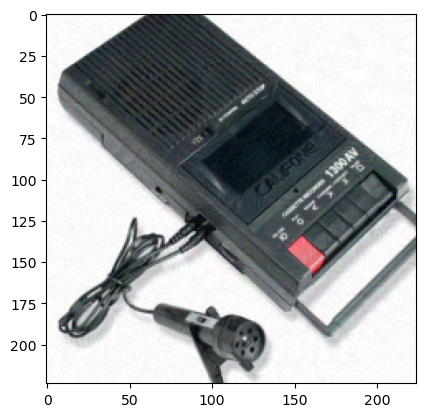

In [38]:
adversarial_image = adversarial_attack((img / 255).unsqueeze(dim=0))
show_image(adversarial_image)

In [27]:
# Helper functions to determine if attack worked
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_idx = r.json()
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

transform_resnet = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
])

model = models.resnet50(pretrained=True).to('cpu').eval()

/opt/homebrew/Caskroom/miniconda/base/envs/10713/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/10713/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
old_class = model(transform_resnet((img / 255).unsqueeze(dim=0))).argmax()
new_class = model(transform_resnet(adversarial_image)).argmax()

print(idx2label[old_class])
print(idx2label[new_class])

tape_player
syringe
